# Setup

In [64]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import os
import plotting

In [65]:
with open("data/hopsworks-token.txt") as f:
    hopsworks_api_key = f.read().rstrip()

In [66]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 8, 13, 53, 0, 594283)

# Hopswork connecting

In [67]:
project = hopsworks.login(api_key_value=hopsworks_api_key)
fs = project.get_feature_store()

secrets = hopsworks.connection(host="c.app.hopsworks.ai", api_key_value=hopsworks_api_key).get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country = location["country"]
city = location["city"]
street = location["street"]

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160342
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [68]:
feature_view = fs.get_feature_view(
    name="air_quality_view",
    version=1,
)

In [69]:
mr = project.get_model_registry()
retrieved_model = mr.get_model(
    name="air_quality_model",
    version=1,
)
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [70]:
retrieved_xgbm = XGBRegressor()
retrieved_xgbm.load_model(os.path.join(saved_model_dir, "model.json"))
retrieved_xgbm

XGBRegressor(base_score='4.902366E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Make the predictions

In [71]:
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=1,
)
air_quality_df_all = air_quality_fg.read().sort_values("date", ascending=False)
air_quality_df = air_quality_df_all.head(3)
lagged = air_quality_df["pm25"].mean()
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data["lagged"] = lagged
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged
0,2024-11-16 00:00:00+00:00,3.45,0.1,8.217153,298.810699,reutlingen,8.506667
1,2024-11-12 00:00:00+00:00,6.35,0.2,10.972620,311.009003,reutlingen,8.506667
2,2024-11-14 00:00:00+00:00,4.60,0.0,16.055355,42.273628,reutlingen,8.506667
3,2024-11-11 00:00:00+00:00,8.70,0.0,3.396233,302.005341,reutlingen,8.506667
4,2024-11-13 00:00:00+00:00,7.40,0.1,15.379206,69.443871,reutlingen,8.506667
5,2024-11-09 00:00:00+00:00,12.50,0.0,2.545584,98.130020,reutlingen,8.506667
6,2024-11-15 00:00:00+00:00,3.05,0.1,8.825508,11.768270,reutlingen,8.506667
7,2024-11-10 00:00:00+00:00,10.40,0.0,4.320000,360.000000,reutlingen,8.506667
8,2024-11-17 00:00:00+00:00,3.50,0.0,18.278645,237.875031,reutlingen,8.506667


In [72]:
batch_data["predicted_pm25"] = retrieved_xgbm.predict(
    batch_data[["lagged", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25
0,2024-11-16 00:00:00+00:00,3.45,0.1,8.217153,298.810699,reutlingen,8.506667,8.084450
1,2024-11-12 00:00:00+00:00,6.35,0.2,10.972620,311.009003,reutlingen,8.506667,6.937438
2,2024-11-14 00:00:00+00:00,4.60,0.0,16.055355,42.273628,reutlingen,8.506667,9.748174
3,2024-11-11 00:00:00+00:00,8.70,0.0,3.396233,302.005341,reutlingen,8.506667,10.110997
4,2024-11-13 00:00:00+00:00,7.40,0.1,15.379206,69.443871,reutlingen,8.506667,4.966533
5,2024-11-09 00:00:00+00:00,12.50,0.0,2.545584,98.130020,reutlingen,8.506667,6.614818
6,2024-11-15 00:00:00+00:00,3.05,0.1,8.825508,11.768270,reutlingen,8.506667,17.143177
7,2024-11-10 00:00:00+00:00,10.40,0.0,4.320000,360.000000,reutlingen,8.506667,8.838960
8,2024-11-17 00:00:00+00:00,3.50,0.0,18.278645,237.875031,reutlingen,8.506667,4.220146


In [73]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged                       9 non-null      float64            
 7   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1), object(1)
memory usage: 528.0+ bytes


In [74]:
batch_data["street"] = street
batch_data["city"] = city
batch_data["country"] = country
batch_data["days_before_forecast_day"] = range(1, len(batch_data) + 1)
batch_data = batch_data.sort_values(by=["date"])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25,street,country,days_before_forecast_day
5,2024-11-09 00:00:00+00:00,12.50,0.0,2.545584,98.130020,reutlingen,8.506667,6.614818,zaisentalstraße,germany,6
7,2024-11-10 00:00:00+00:00,10.40,0.0,4.320000,360.000000,reutlingen,8.506667,8.838960,zaisentalstraße,germany,8
3,2024-11-11 00:00:00+00:00,8.70,0.0,3.396233,302.005341,reutlingen,8.506667,10.110997,zaisentalstraße,germany,4
1,2024-11-12 00:00:00+00:00,6.35,0.2,10.972620,311.009003,reutlingen,8.506667,6.937438,zaisentalstraße,germany,2
4,2024-11-13 00:00:00+00:00,7.40,0.1,15.379206,69.443871,reutlingen,8.506667,4.966533,zaisentalstraße,germany,5
2,2024-11-14 00:00:00+00:00,4.60,0.0,16.055355,42.273628,reutlingen,8.506667,9.748174,zaisentalstraße,germany,3
6,2024-11-15 00:00:00+00:00,3.05,0.1,8.825508,11.768270,reutlingen,8.506667,17.143177,zaisentalstraße,germany,7
0,2024-11-16 00:00:00+00:00,3.45,0.1,8.217153,298.810699,reutlingen,8.506667,8.084450,zaisentalstraße,germany,1
8,2024-11-17 00:00:00+00:00,3.50,0.0,18.278645,237.875031,reutlingen,8.506667,4.220146,zaisentalstraße,germany,9


In [75]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 5 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged                       9 non-null      float64            
 7   predicted_pm25               9 non-null      float32            
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64         

# Monitoring and graphing

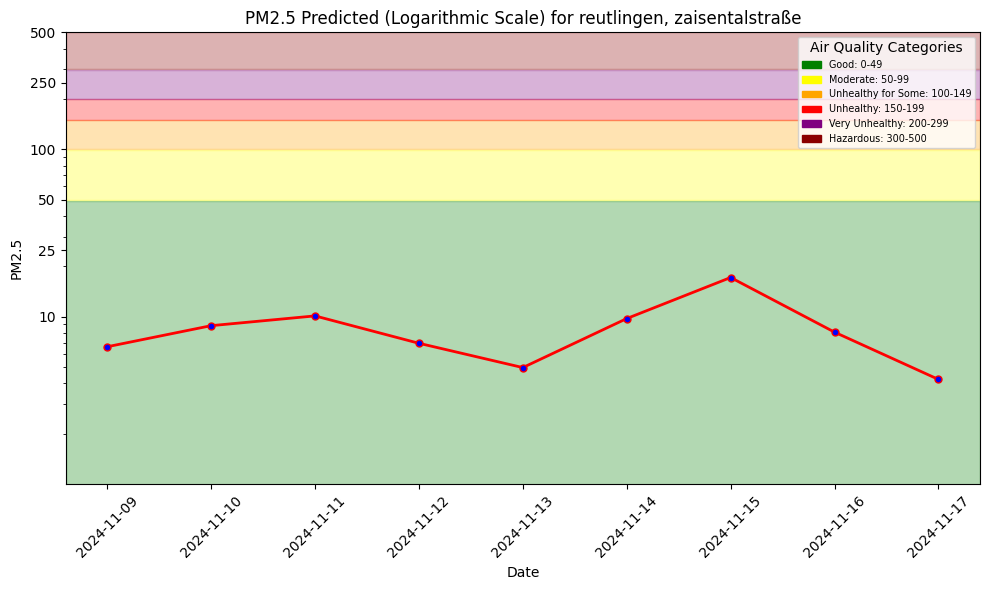

In [76]:
forecast_path = os.path.join("aqm", "images", "fc.png")
plt = plotting.plot_air_quality_forecast(city, street, batch_data, forecast_path)
plt.show()

In [77]:
monitor_fg = fs.get_or_create_feature_group(
    name="aq_predictions",
    description="Air Quality prediction monitoring",
    version=1,
    primary_key=["city", "street", "date", "days_before_forecast_day"],
    event_time="date"
)

In [78]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 5 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged                       9 non-null      float64            
 7   predicted_pm25               9 non-null      float32            
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64         

In [79]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1160342/fs/1151045/fg/1342805


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160342/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x10a09c170>, None)

In [80]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.77s) from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-16 00:00:00+00:00,3.45,0.1,8.217153,298.810699,reutlingen,8.506667,8.08445,zaisentalstraße,germany,1


In [84]:
outcome_df = air_quality_df_all[["date", "pm25"]]
preds_df =  monitoring_df[["date", "predicted_pm25"]]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=["date"])

def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    # Here we should use the true values of lagged and not the one we spitballed.
    features_df = pd.merge(features_df, air_quality_df[["date", "lagged"]], on="date")
    features_df['predicted_pm25'] = model.predict(features_df[['lagged', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date','pm25','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgbm)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160342/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,9.05,0.0,6.297428,120.963684,reutlingen,6.973333,10.827231,12.0,zaisentalstraße,germany,1


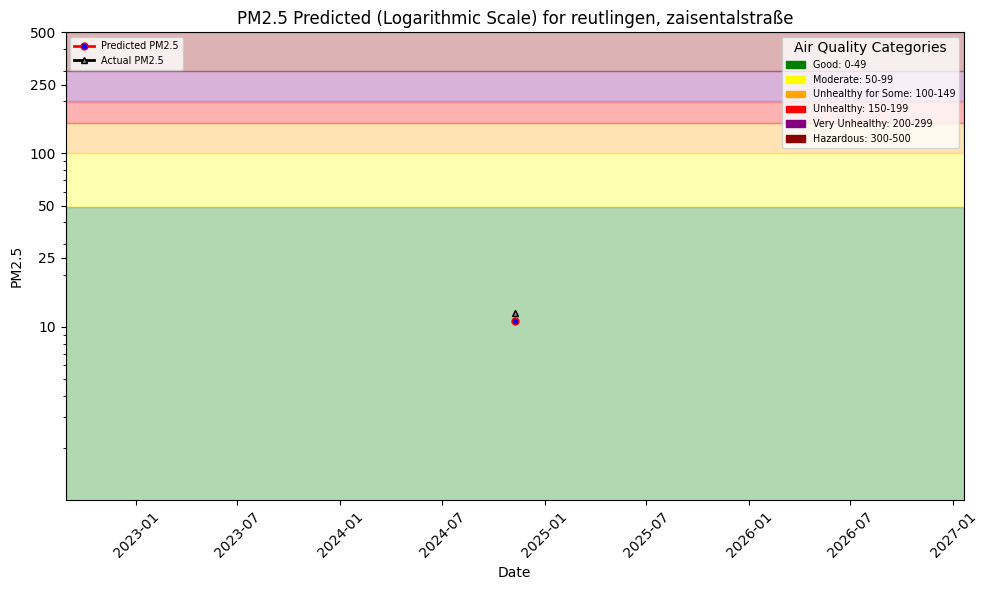

In [85]:
hindcast_path = os.path.join("aqm", "images", "hc.png")
plt = plotting.plot_air_quality_forecast(city, street, hindcast_df, hindcast_path, hindcast=True)
plt.show()